# url: https://www.ritolab.com/posts/246

# データの類似性を探る〜k-means 法を用いた非階層クラスター分析〜

似たような傾向にあるデータを分類し、何らかの洞察を得たい。

データを一定の規則で分類し類似性を探る「クラスター分析」その中でも k-means 法を用いた非階層クラスター分析を行なってみます。

## クラスター分析（クラスタリング）
クラスター分析は、ある集団を類似度によってグループ化（分類）する分析手法。クラスタリングとも呼ばれる。

データの構造に関する直感を得るために使用される最も一般的な探索的データ分析手法の1つ。

データを一定の規則で分類することで、そのデータの特性を把握しやすくなる。

（例えば、集団 A は肉が好き。集団 B は魚が好き。集団 C は肉も魚も好き。のような洞察を得られたりする）

機械学習では「教師なし学習」に分類される。

## クラスター分析の種類
### 階層クラスター分析
    デンドログラム（樹形図）を作成しクラスタリングを行う。
    グルーピングされていく過程を確認したい時に有効（事前のクラスタ数の決定も不要）。ただし、データ数が多いと時間がかかる。

### 非階層クラスター分析
    デンドログラム等は作成せず、クラスタリングを行う。
    クラスタ数を予め決定しておく必要がある。

## K-Means 法（K-Means algorithms）
K-Means 法は、予め定義された K 個の重複しないクラスタにデータセットを分割しようとする反復アルゴリズム。

1. 指定されたクラスタ数で各データポイントをランダムにクラスタ分けする。
2. 各クラスタの重心を算出する。
3. 各データポイントを、算出された重心に近いところへクラスタ再分類する
4. 再分類されたクラスタの重心を再計算し、重心を再配置する。

3, 4 を反復して行い、データポイントのクラスタ移動がなくなったら終了。

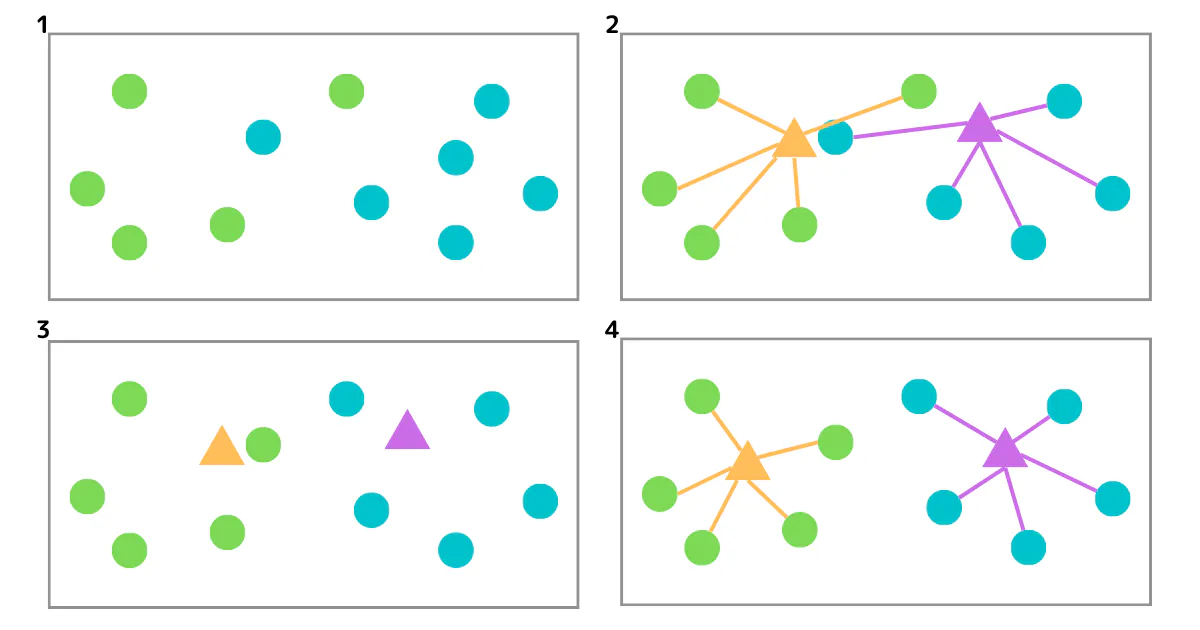

## python でクラスター分析
それではクラスター分析を行なっていきます。

python の機械学習ライブラリ scikit-learn を用いて k-means 法による非階層クラスター分析を実施していきます。

## 卸売業者の顧客データ
サンプルのデータセットとして今回は、カルフォルニア大学（UC バークレー）から公開されている「卸売業者の顧客データ」を利用します。

UCI Machine Learning Repository: Wholesale customers Data

url: https://archive.ics.uci.edu/dataset/292/wholesale+customers

## データ確認
データセットの中身を確認します。

In [1]:
import pandas as pd

df = pd.read_csv('/content/Wholesale customers data.csv')

df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


各カラムの意味は以下の通り

    column	詳細
    Channel	顧客チャネル - Horeca (ホテル/レストラン/カフェ) or 小売
    Region	地域
    Fresh	生鮮品の年間支出額
    Milk	乳製品の年間支出額
    Grocery	食料品の年間支出額
    Frozen	冷凍食品の年間支出額
    Detergents_Paper	洗剤・紙類の年間支出額
    Delicassen	惣菜の年間支出額
    
名義尺度である Channel と Region は外して、支出額でクラスタリングします。

In [2]:
df_train = df

# Channel, Region カラムを除去
df_train = df_train.drop(['Channel', 'Region'], axis=1)

display(df_train.head())

# 記述統計を確認します。
display(df_train.describe(include = 'all'))
# それぞれ min/max の幅が大きいので、度数分布表とヒストグラムを出力して各カラムにおけるデータの状況を確認しておきます。
# 値が大きく、飛び抜けているデータが 1 件ありました。（飛び抜けてはいるが外れ値ではないと解釈し、データ自体は含めます。最終的にこの飛び抜けたデータもしっかり分類されていれば良し。）
# 支出額については上限（最大値）があるわけではないので、データは標準化してスケールしておきます。

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


## 標準化
飛び抜けている数値があったので、RobustScaler で標準化します。

url: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

Compare the effect of different scalers on data with outliers

url: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

In [3]:
# データを標準化
from sklearn import preprocessing
rs = preprocessing.RobustScaler()

rs.fit(df_train)
arr_rs = rs.transform(df_train)

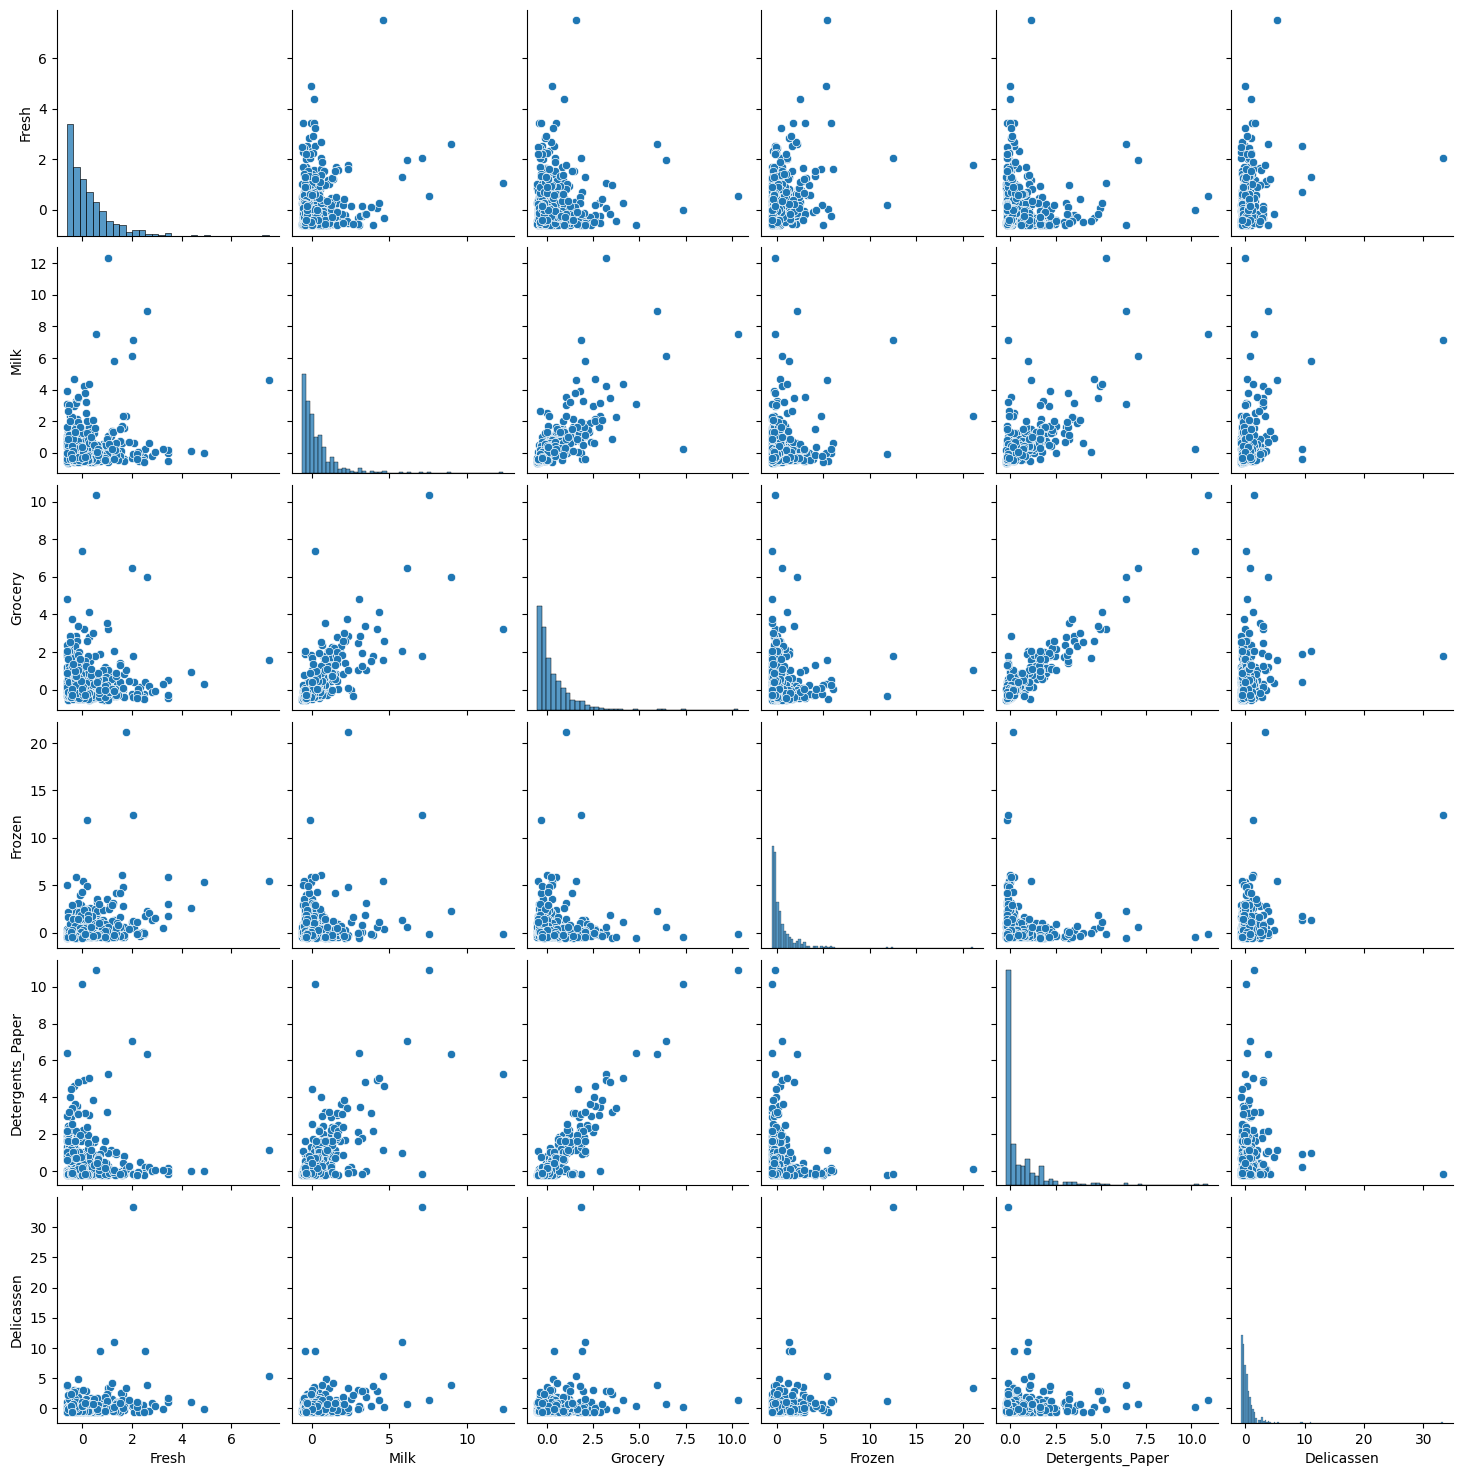

In [4]:
# ペアプロット図で変数間の関係を見ておきます。
import seaborn as sns
train_rs = pd.DataFrame(arr_rs, columns=df_train.columns.values)
sns.pairplot(train_rs)

いくつか正の相関が見られるものがあります。今回は相関関係は関係ないですが、こういうところをさらっと見ておくだけでもデータを別の視点で探索していく上でのヒントになりそうです。

では、改めてデータと記述統計を確認します。

In [5]:
# データ確認
display(train_rs.head())

# 記述統計
display(train_rs.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.301680,1.065712,0.329952,-0.466572,0.506787,0.263810
1,-0.104810,1.092934,0.565993,0.083926,0.675670,0.574008
2,-0.155802,0.915816,0.344418,0.312589,0.736512,4.871459
3,0.344850,-0.429714,-0.062862,1.734708,-0.084442,0.582507
4,1.022092,0.315171,0.287260,0.849573,0.262056,2.988314


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.253245,0.383449,0.375852,0.549762,0.563398,0.396155
std,0.916075,1.304587,1.117658,1.726413,1.300827,1.997242
min,-0.615747,-0.631402,-0.558937,-0.533784,-0.221949,-0.681657
25%,-0.389414,-0.370145,-0.306077,-0.278716,-0.152718,-0.394653
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.610586,0.629855,0.693923,0.721284,0.847282,0.605347
max,7.507388,12.350700,10.352474,21.103485,10.916172,33.270184


標準化されていることを確認できました。

## 次元削減
プロット解釈と処理高速化のために次元削減を行なっておきます。

PCA（主成分分析）でデータを 2 次元にまとめます。



In [6]:
from sklearn.decomposition import PCA

# 次元削減
pca = PCA(n_components=2)
pca.fit(train_rs)
arr_2d = pca.transform(train_rs)
train_2d = pd.DataFrame(arr_2d, columns=["pca_1","pca_2"])

次元削減後のプロットを見てみます。

<Axes: xlabel='pca_1', ylabel='pca_2'>

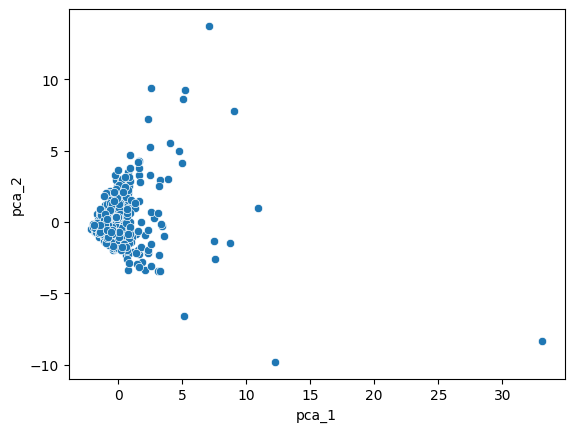

In [7]:
sns.scatterplot( x='pca_1', y='pca_2', data=train_2d)

## クラスタリング数の決定
非階層クラスター分析では、予めクラスター数を決めなければいけません。

k-means 法での最適なクラスター数を探るために、「エルボー法」を使って見てみます。

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

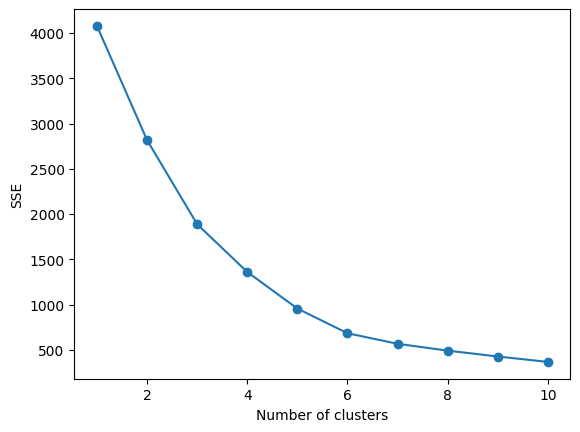

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

list_sse = []

for i  in range(1,11):
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(train_2d)
    list_sse.append(km.inertia_)

plt.plot(range(1,11), list_sse,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

5, ないしは 6 あたりが最適そうです。

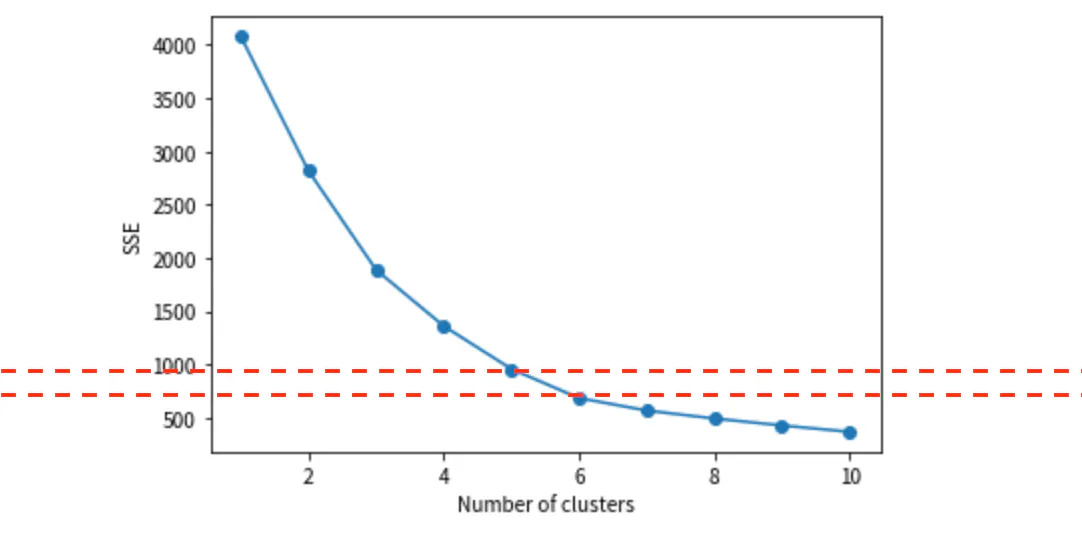

初めから増やしすぎてもクラスタの解釈が難しくなるため、クラスタ数は 5 でいきます。

## クラスタリング
データの準備とクラスタ数の決定まで行い、クラスタリングの準備が整いました。

k-means 法で非階層クラスター分析を実行していきます。

In [9]:
from sklearn.cluster import KMeans

# クラスタ数
number_cluster = 5

kmeans = KMeans(n_clusters=number_cluster, random_state=0)
kmeans.fit(train_2d)
pred = kmeans.predict(train_2d)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


クラスタリング結果を先ほどのプロットに反映して見てみます。

<Axes: xlabel='pca_1', ylabel='pca_2'>

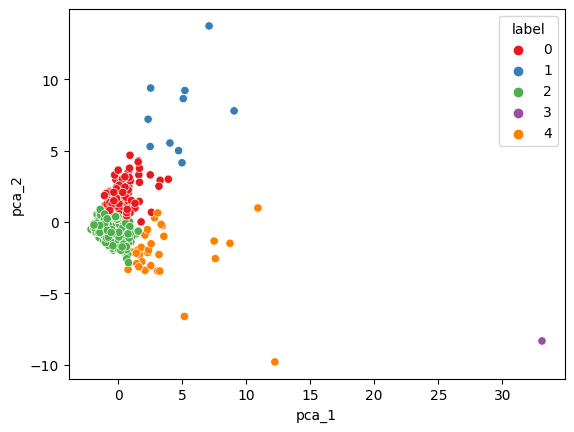

In [10]:
train_2d["label"] = pred
train_2d["label"] = train_2d["label"].astype("int")

# 可視化
sns.scatterplot( x='pca_1', y='pca_2', hue="label",data=train_2d,palette="Set1")

目視の限りでは、良い感じにクラスタリングできていそうです。

## クラスタを分析
分類したデータを分析してみます。それぞれのクラスタごとに、各部門の支出額平均を積み上げてグラフで可視化してみます。

In [11]:
# 分類したデータを分析してみます。それぞれのクラスタごとに、各部門の支出額平均を積み上げてグラフで可視化してみます。
pred_df = pd.DataFrame(pred, columns=['k_means'])
df_train = pd.concat([df_train, pred_df], axis = 1)
display(df_train['k_means'].value_counts().sort_index())

0    103
1     10
2    295
3      1
4     31
Name: k_means, dtype: int64

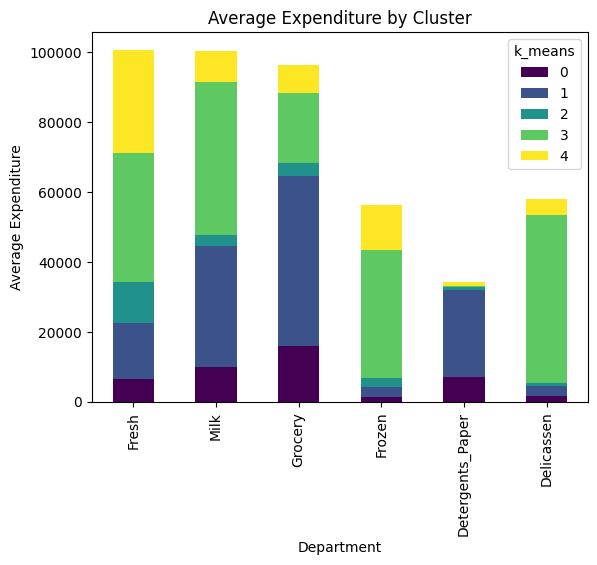

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# クラスタごとの平均を計算
cluster_means = df_train.groupby('k_means').mean()

# グラフの描画
cluster_means.T.plot(kind='bar', stacked=True, colormap='viridis')

# グラフにタイトルやラベルを追加（任意）
plt.title('Average Expenditure by Cluster')
plt.xlabel('Department')
plt.ylabel('Average Expenditure')

# グラフを表示
plt.show()

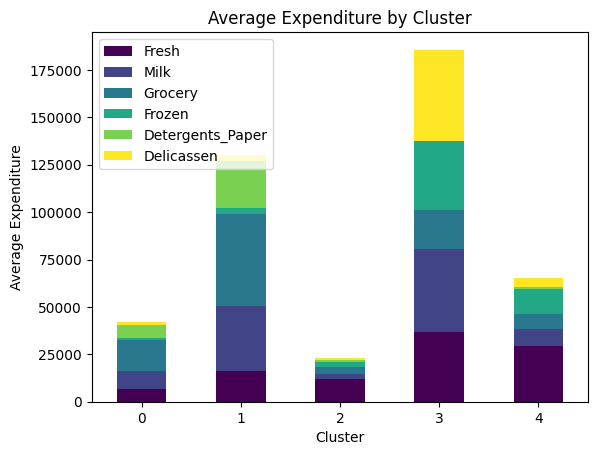

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# クラスタごとの平均を計算
cluster_means = df_train.groupby('k_means').mean()

# グラフの描画
ax = cluster_means.plot(kind='bar', stacked=True, colormap='viridis')

# x軸のラベルを90度回転
plt.xticks(rotation=0)

# グラフにタイトルやラベルを追加（任意）
plt.title('Average Expenditure by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Expenditure')

# グラフを表示
plt.show()

グラフの脇にそれぞれのクラスタの分類数を載せました。

クラスタ 1 と 3 は支出額が大きいですが、分類数が少ないため、大手の卸売業者かもしれません。

それらを除いたクラスタ 0, 2, 4 で見てみると、クラスタ 2 と 4 は支出の内訳が似ています。クラスタ 2 の規模が大きいグループがクラスタ 4 かもしれません。そしてこれらは、生鮮品の卸がメインであることがわかります。

クラスタ 0 は、支出額的にはクラスタ 2 と 4 の間にいますが、それぞれの支出配分を見ると、クラスタ 2 と 4 は生鮮品がメインであるのに対して、クラスタ 0 は食料品がメインであることがわかります。

こんな具合で、クラスタリングしたことでデータを一定のセグメントに分けられました。

ちなみにこのデータセットには卸売業者の販売チャネルもあったので、チャネルごとにクラスタリングしてみます。

### データが意味を持つように
「顧客データが溜まってきたけれど、これらの顧客はどういった傾向にある顧客なのか。」

ただデータだけあって、そのデータから何もつかめていない。そんな時にこういったクラスター分析によってデータの一定の類似性を発見でき、それによってさらに深くデータを分析していくそのきっかけにできる。まさに「探索的データ分析手法」であり、データの構造に関する直感を得るために使用される。

「そのデータが意味を持つ瞬間」を体験でき、 クラスター分析で得られる知見を実感できました。